In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
import os
import tensorflow_datasets as tfds 
from sklearn.model_selection import train_test_split
from PIL import Image , ImageDraw , ImageFont

2025-08-09 23:57:43.127745: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-09 23:57:44.389600: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<img src='https://storage.googleapis.com/tensorflow-3-public/assets/images/m2nist_segmentation.png' alt='m2nist digits'>
 build a Convolutional Neural Network (CNN) from scratch for the downsampling path and use a Fully Convolutional Network, FCN-8, to upsample and produce the pixel-wise label map. The model will be evaluated using the intersection over union (IOU) and Dice Score. 

In [2]:
BATCH_SIZE = 32 


In [3]:
def ultimate_mapping(image , annotation):

    image = tf.cast(image , tf.float32)
    image = tf.reshape(image , (image.shape[0] , image.shape[1] , 1 ,))
    annotation = tf.cast(annotation ,dtype = tf.int32)
    image = image/127.5
    image -=1 

    return image , annotation

In [4]:
def get_training_dataset(slices):
    images , annos = slices
    dataset = tf.data.Dataset.from_tensor_slices((images , annos))
    dataset = dataset.map(ultimate_mapping)

    dataset = dataset.shuffle(512 ,reshuffle_each_iteration = True)
    dataset = dataset.batch(BATCH_SIZE).repeat()
    dataset = dataset.prefetch(-1)

    return dataset 

In [5]:
def get_validation_dataset(slices ):
    images , annos = slices 
    dataset = tf.data.Dataset.from_tensor_slices((images , annos))
    dataset = dataset.map(ultimate_mapping)

    dataset = dataset.batch(BATCH_SIZE).repeat()
    return dataset 

## Loading and Preprocessing Data

1. **combined.npy** has the image files containing the multiple MNIST digits. Each image is of size **64 x 84** (height x width, in pixels).

2. **segmented.npy** has the corresponding segmentation masks. Each segmentation mask is also of size **64 x 84**.

This dataset has **5000** samples and you can make appropriate training, validation, and test splits as required for the problem.

In [6]:
def get_test_dataset(slices ):
    images , annos  = slices
    dataset = tf.data.Dataset.from_tensor_slices((images , annos))
    dataset =dataset.map(ultimate_mapping)
    dataset = dataset.batch(BATCH_SIZE  ,  drop_remainder= True)
    return dataset  

In [7]:
def load_images_and_segments():

    images = np.load("/root/code/DeepLabV3Plus-Pytorch/data/combined.npy")
    segments =np.load("/root/code/DeepLabV3Plus-Pytorch/data/segmented.npy")

    train_images , val_images , train_annos , val_annos = train_test_split(images , segments , test_size = 0.2 , random_state = 42)
    val_images , test_images , val_annos , test_annos = train_test_split(val_images , val_annos , test_size= 0.2 , random_state = 42)

    return (train_images , train_annos) , (val_images , val_annos) , (test_images , test_annos)
    

In [8]:
train_slices , valid_slices , test_slices = load_images_and_segments()

In [9]:
train_dataset = get_training_dataset(train_slices)
test_dataset = get_test_dataset(test_slices)
valid_dataset = get_validation_dataset(valid_slices)

2025-08-09 23:57:53.065771: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:67:01.0, compute capability: 7.0
2025-08-09 23:57:56.204286: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1892352000 exceeds 10% of free system memory.
2025-08-09 23:57:58.781605: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1892352000 exceeds 10% of free system memory.
2025-08-09 23:58:02.416028: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 378470400 exceeds 10% of free system memory.
2025-08-09 23:58:03.043100: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 378470400 exceeds 10% of free system memory.


In [10]:
n_classes = 11 # 0-9 + background class 

colors = [tuple(np.random.randint(256 , size = 3 )/255.0) for i in range(n_classes)]

In [11]:

def fuse_with_pil(images):
    widths =(image.shape[1] for image in images)
    heights = (image.shape[0] for image in images)
    total_width = sum(widths)
    total_heights = sum(heights)

    new_img = Image.new("RGB" , (total_width , total_heights))

    x_offset = 0 
    for im in images:
        pil_img = Image.fromarray(np.uint8(im))
        new_img.paste(pil_img , (x_offset , 0))
        x_offset+=im.shape[1]
    return new_img

In [12]:
def give_color_to_annotation(annotation):

    seg_img = np.zeros((annotation.shape[0] , annotation.shape[1] , 3)  ).astype("float32")

 
    for c in range(n_classes):
        segc = (annotation == c)
        seg_img[:,:,0] += segc*( colors[c][0] * 255.0)
        seg_img[:,:,1] += segc*( colors[c][1] * 255.0)
        seg_img[:,:,2] += segc*( colors[c][2] * 255.0)

    return seg_img


In [13]:
def show_annotation_and_prediction(image, annotation, prediction, iou_list, dice_score_list):
    new_ann = np.argmax(annotation, axis=2)
    true_img = give_color_to_annotation(new_ann)
    pred_img = give_color_to_annotation(prediction)

    image = image + 1
    image = image * 127.5
    image = np.reshape(image, (image.shape[0], image.shape[1],))
    image = np.uint8(image)
    images = [image, np.uint8(pred_img), np.uint8(true_img)]

    metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list,
                                                                dice_score_list)) if iou > 0.0 and idx < 10]
    metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  

    display_string_list = [f"{idx}: IOU: {iou} Dice Score: {dice_score}"for idx, iou, dice_score in metrics_by_id]
    display_string = "\n".join(display_string_list)

    plt.figure(figsize=(15, 4))

    for idx, im in enumerate(images):
        plt.subplot(1, 3, idx+1)
        if idx == 1:
            plt.xlabel(display_string)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(im)

In [14]:

def show_annotation_and_image(image, annotation):
    new_ann = np.argmax(annotation, axis=2)
    seg_img = give_color_to_annotation(new_ann)

    image = image + 1
    image = image * 127.5
    image = np.reshape(image, (image.shape[0], image.shape[1],))

    image = np.uint8(image)
    images = [image, seg_img]

    fused_img = fuse_with_pil(images)
    plt.imshow(fused_img)

In [15]:
def list_show_annotation(dataset, num_images):
    ds = dataset.unbatch()

    plt.figure(figsize=(20, 15))
    plt.title("Images And Annotations")
    plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.05)

    for idx, (image, annotation) in enumerate(ds.take(num_images)):
        plt.subplot(5, 5, idx + 1)
        plt.yticks([])
        plt.xticks([])
        show_annotation_and_image(image.numpy(), annotation.numpy())


2025-08-09 23:58:03.835674: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1892352000 exceeds 10% of free system memory.
/tmp/ipykernel_15309/4203448702.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 5, idx + 1)


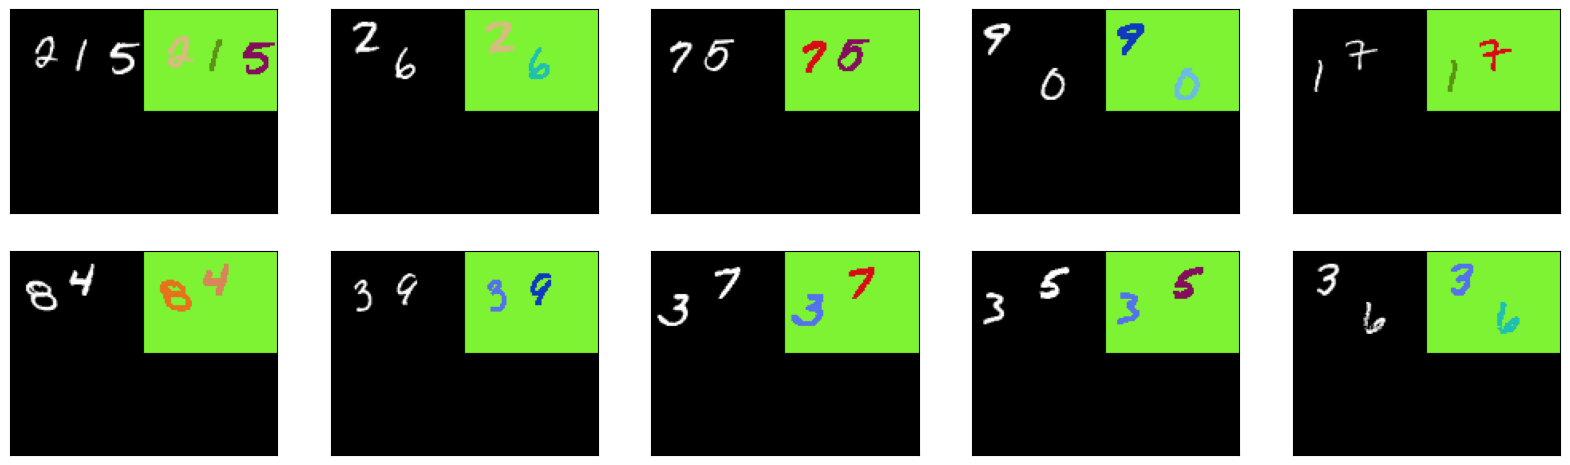

In [16]:
list_show_annotation(train_dataset, 10)

/tmp/ipykernel_15309/4203448702.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 5, idx + 1)


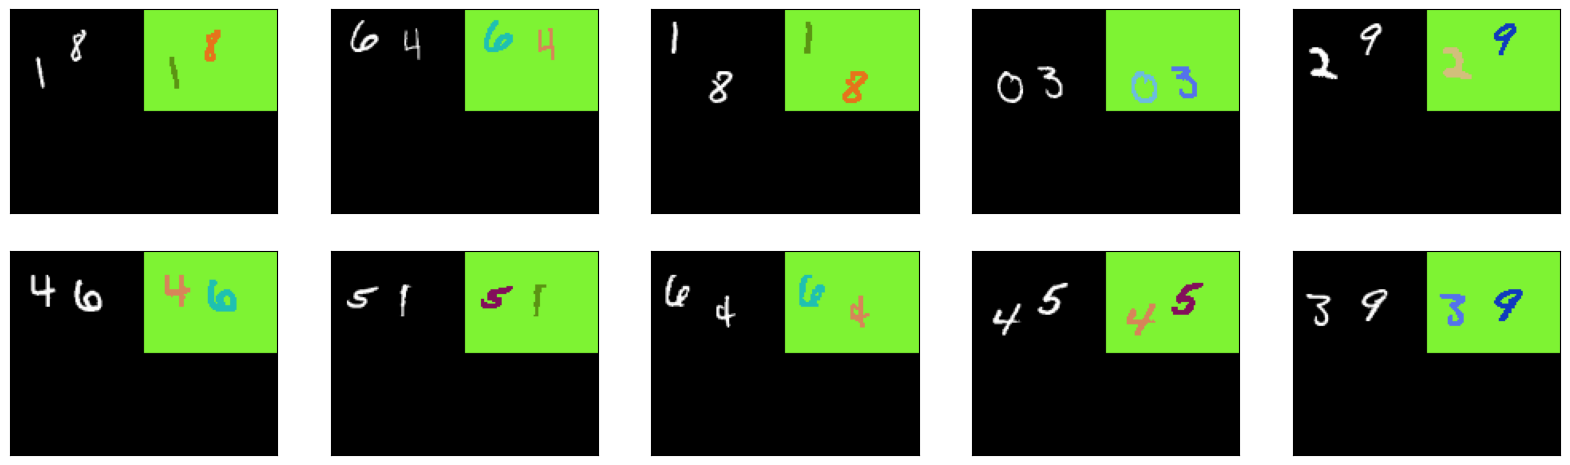

In [17]:
list_show_annotation(valid_dataset, 10)

## Define The Model
----
the image segmentation model will have two paths:

1. **Downsampling Path** - This part of the network extracts the features in the image. This is done through a series of convolution and pooling layers. The final output is a reduced image (because of the pooling layers) with the extracted features. You will build a custom CNN from scratch for this path.

2. **Upsampling Path** - This takes the output of the downsampling path and generates the predictions while also converting the image back to its original size. You will use an FCN-8 decoder for this path.

In [18]:
IMAGE_ORDERING = "channels_last"

def conv_block(inputs , filters , kernel_size , pool_size ,pool_strides):
    x = tf.keras.layers.Conv2D(filters , kernel_size , padding = "same" , data_format = IMAGE_ORDERING)(inputs)
    x = tf.keras.layers.LeakyReLU(alpha = 0.3)(x)
    x = tf.keras.layers.Conv2D(filters , kernel_size ,padding = "same",data_format = IMAGE_ORDERING )(x)
    x = tf.keras.layers.LeakyReLU(alpha = 0.3)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size = (pool_size,pool_size) , strides = pool_strides)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return x 

To optimize processing or to make the output dimensions of each layer easier to work with, it is sometimes advisable to apply some zero-padding to the input image. With the boilerplate code we have provided below, we have padded the input width to 96 pixels using the `ZeroPadding2D`

In [19]:
def FCN8(input_height= 64 ,input_width = 84 ):
    img_input = tf.keras.layers.Input(shape = (input_height,input_width,1))
    x = tf.keras.layers.ZeroPadding2D(((0, 0), (0, 96- input_width)))(img_input)
    
    x = conv_block(x , filters = 32 , kernel_size = 3 , pool_size = 2 , pool_strides = 2)
    x = conv_block(x , filters = 64 , kernel_size = 3 , pool_size = 2 , pool_strides = 2)
    x = conv_block(x , filters = 128 , kernel_size = 3 , pool_size = 2 , pool_strides = 2)

    f3 = x 
    x = conv_block(x , filters = 256 , kernel_size = 3 , pool_size = 2 , pool_strides = 2)
    f4 = x 
    x = conv_block(x , filters = 256 , kernel_size = 3 , pool_size = 2 , pool_strides = 2)
    f5 = x 
    return (f3 , f4 ,f5 ), img_input

In [20]:
def fcn8_decoder(convs , n_classes):
    f3 , f4 , f5 = convs
    n = 512 
    o = tf.keras.layers.Conv2D(n , (7 , 7) , activation='relu' , padding='same', name="conv6", data_format=IMAGE_ORDERING)(f5)
    o = tf.keras.layers.Dropout(0.5)(o)

    o = tf.keras.layers.Conv2D(n , (1 , 1) , activation='relu' , padding='same', name="conv7", data_format=IMAGE_ORDERING)(o)
    o = tf.keras.layers.Dropout(0.5)(o)

    o = tf.keras.layers.Conv2D(n_classes,  (1, 1), activation='relu' , padding='same', data_format=IMAGE_ORDERING)(o)
    
    o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size = (4,4), strides = (2,2) ,
                                        padding ="valid" ,use_bias = False, data_format=IMAGE_ORDERING )(o)
    o = tf.keras.layers.Cropping2D(cropping = (1,1))(o)
    
    o2 = f4
    o2 = tf.keras.layers.Conv2D(n_classes, kernel_size =(1,1),data_format=IMAGE_ORDERING)(o2)
    
    o = tf.keras.layers.concatenate([o , o2])
    
      
    o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size = (4,4), strides = (2,2) ,
                                        padding ="valid" ,use_bias = False, data_format=IMAGE_ORDERING )(o)
    o = tf.keras.layers.Cropping2D(cropping = (1,1))(o)
    o2 = f3 
    o2 = tf.keras.layers.Conv2D(n_classes, kernel_size =(1,1),activation ="relu" , padding ="same" , data_format=IMAGE_ORDERING)(o2)
    o = tf.keras.layers.concatenate([o, o2])
    o = tf.keras.layers.Conv2DTranspose(filters=n_classes, kernel_size=(8, 8), strides=(8, 8), 
                                      padding="valid", use_bias=False, data_format=IMAGE_ORDERING)(o)
    o = tf.keras.layers.Cropping2D(((0, 0), (0, 96-84)))(o)

    o = (tf.keras.layers.Activation('sigmoid'))(o)
    return o 

In [21]:
convs , img_input = FCN8()
dec_output = fcn8_decoder(convs , n_classes)
model = tf.keras.Model(inputs = img_input, outputs = dec_output)

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 84, 1)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 64, 96, 1)            0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv2d (Conv2D)             (None, 64, 96, 32)           320       ['zero_padding2d[0][0]']      
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 64, 96, 32)           0         ['conv2d[0][0]']          

## Training

In [23]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=1E-2, momentum=0.9, nesterov=True), 
              metrics=['accuracy'])

In [24]:
EPOCHS = 100

steps_per_epoch = 4000//BATCH_SIZE
validation_steps = 800//BATCH_SIZE
test_steps = 200//BATCH_SIZE


history = model.fit(train_dataset,
                    steps_per_epoch=steps_per_epoch, validation_data=valid_dataset, validation_steps=validation_steps, epochs=EPOCHS)

Epoch 1/100


2025-08-09 23:58:12.433784: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-08-09 23:58:12.844420: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-08-09 23:58:14.058204: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f41463fcb30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-09 23:58:14.058240: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2025-08-09 23:58:14.140457: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 [==============================] - 9s 27ms/step - loss: 1.0313 - accuracy: 0.7317 - val_loss: 0.5114 - val_accuracy: 0.9422
Epoch 2/100
125/125 [==============================] - 2s 20ms/step - loss: 0.2355 - accuracy: 0.9426 - val_loss: 0.3637 - val_accuracy: 0.9422
Epoch 3/100
125/125 [==============================] - 2s 20ms/step - loss: 0.2269 - accuracy: 0.9426 - val_loss: 0.2777 - val_accuracy: 0.9422
Epoch 4/100
125/125 [==============================] - 2s 20ms/step - loss: 0.2222 - accuracy: 0.9426 - val_loss: 0.2373 - val_accuracy: 0.9422
Epoch 5/100
125/125 [==============================] - 3s 20ms/step - loss: 0.2185 - accuracy: 0.9426 - val_loss: 0.2233 - val_accuracy: 0.9422
Epoch 6/100
125/125 [==============================] - 3s 22ms/step - loss: 0.2152 - accuracy: 0.9426 - val_loss: 0.2165 - val_accuracy: 0.9423
Epoch 7/100
125/125 [==============================] - 3s 28ms/step - loss: 0.2121 - accuracy: 0.9426 - val_loss: 0.2130 - val_accuracy: 0.9423
Epoc

 get the *index* of the highest probability of each of these 11 slices and combine them in a single image. We can do that by getting the `argmax`

In [25]:
results = model.predict(test_dataset , steps = test_steps)
print(results.shape)
results = np.argmax(results, axis=3)
print(results.shape)

6/6 [==============================] - 0s 5ms/step
(192, 64, 84, 11)
(192, 64, 84)


## IOU

In [26]:
def class_wise_metrics(y_true, y_pred):
    class_wise_iou = []
    class_wise_dice_score = []

    smoothing_factor = 0.00001

    for i in range(n_classes):
        intersection = np.sum((y_pred == i) * (y_true == i))
        y_true_area = np.sum((y_true == i))
        y_pred_area = np.sum((y_pred == i))
        combined_area = y_true_area + y_pred_area

        iou = (intersection) / (combined_area - intersection + smoothing_factor)
        class_wise_iou.append(iou)

        dice_score =  2 * ((intersection) / (combined_area + smoothing_factor))
        class_wise_dice_score.append(dice_score)

    return class_wise_iou, class_wise_dice_score


## Prediction

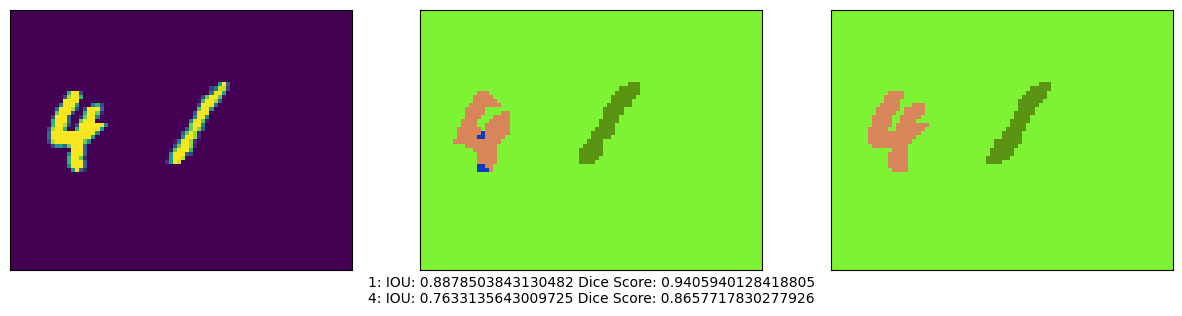

In [27]:
integer_slider = 105

ds = test_dataset.unbatch()
ds = ds.batch(200)
images = []

y_true_segments = []
for image, annotation in ds.take(2):
    y_true_segments = annotation
    images = image


iou, dice_score = class_wise_metrics(np.argmax(y_true_segments[integer_slider], axis=2), results[integer_slider])
show_annotation_and_prediction(image[integer_slider], annotation[integer_slider], results[integer_slider], iou, dice_score)


In [28]:
cls_wise_iou, cls_wise_dice_score = class_wise_metrics(np.argmax(y_true_segments, axis=3), results)

average_iou = 0.0
for idx, (iou, dice_score) in enumerate(zip(cls_wise_iou[:-1], cls_wise_dice_score[:-1])):
  print("Digit {}: IOU: {} Dice Score: {}".format(idx, iou, dice_score))
  average_iou += iou


Digit 0: IOU: 0.751411011223616 Dice Score: 0.8580635914794732
Digit 1: IOU: 0.7528455269251108 Dice Score: 0.8589981437163751
Digit 2: IOU: 0.7353888621945255 Dice Score: 0.8475205508286745
Digit 3: IOU: 0.6992215872348505 Dice Score: 0.8229904710340884
Digit 4: IOU: 0.6490105923465709 Dice Score: 0.7871515141973922
Digit 5: IOU: 0.6528619104303846 Dice Score: 0.789977561114452
Digit 6: IOU: 0.7547198526876981 Dice Score: 0.8602169189933042
Digit 7: IOU: 0.7285170019352095 Dice Score: 0.8429387748220908
Digit 8: IOU: 0.7058114612937715 Dice Score: 0.8275374826693324
Digit 9: IOU: 0.6252521845574106 Dice Score: 0.7694217432818644
